# LSTM 

## Import all relevant libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import tensorflow_docs as tfdocs
from keras.optimizers import adam
from keras.utils import plot_model
from tensorflow import keras
from keras.models import Sequential, save_model, load_model
from keras.layers import LSTM,Dense, Dropout, GRU
from sklearn.preprocessing import MinMaxScaler


C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\CZ\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1)

## Data Visualization

In [2]:
abl = pd.read_csv('ABL PA Equity.csv')
abl.tail()

,Date,Open,High,Low,Close,Volume
3948,10/5/2020,86.99,92.44,81.04,83.83,63500
3949,10/6/2020,83.11,85.47,83.00,83.00,50000
3950,10/7/2020,82.60,84.35,82.50,82.94,37500
3951,10/8/2020,82.91,89.16,82.36,86.73,79000
3952,10/8/2020,82.91,89.16,82.36,86.73,79000


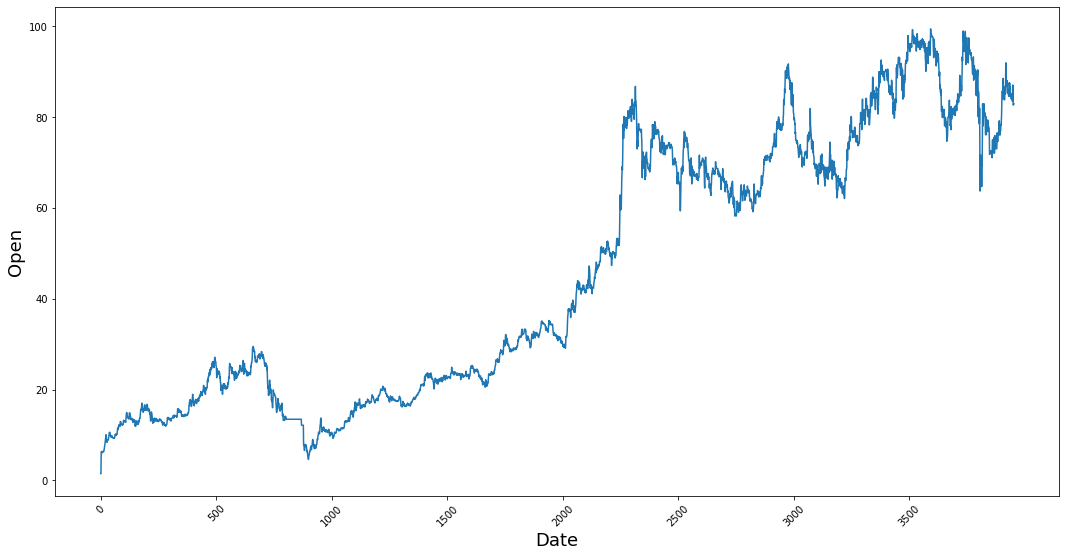

In [3]:
plt.figure(figsize = (18,9))
plt.plot(range(abl.shape[0]), abl['Open'])
plt.xticks(range(0, abl.shape[0], 500), rotation=45)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open', fontsize=18)
plt.show()

## Test-Train-Validation Split

In [4]:
def test_train_split(df):

    open_prices = df['Open'] #We choose to predict the open price

    # 80-20 split into Train-Test

    train_data = open_prices[:int(len(open_prices)*0.8)]
    val_data = open_prices[int(len(open_prices)*0.8):int(len(open_prices)*0.9)]
    test_data = open_prices[int(len(open_prices)*0.9):]
    
    #Convert to ndarray

    train_data = np.asarray(train_data)
    val_data = np.asarray(val_data)
    test_data = np.asarray(test_data)
    
    #Transform data
    
    train_data = train_data.reshape(-1, 1)
    val_data = val_data.reshape(-1, 1)
    test_data = test_data.reshape(-1, 1)
    

    print(train_data.shape[0])
    print(test_data.shape[0])
    print(val_data.shape[0])

    
    return train_data, test_data, val_data
    
train_data, test_data, val_data = test_train_split(abl)

3162
396
395


## Check distribution of data with scaling

{'whiskers': [<matplotlib.lines.Line2D at 0x1e34615b508>,
 'caps': [<matplotlib.lines.Line2D at 0x1e34615bfc8>,
 'boxes': [<matplotlib.patches.PathPatch at 0x1e346156e48>],
 'medians': [<matplotlib.lines.Line2D at 0x1e346165a08>],
 'fliers': [<matplotlib.lines.Line2D at 0x1e346165b08>],
 'means': []}

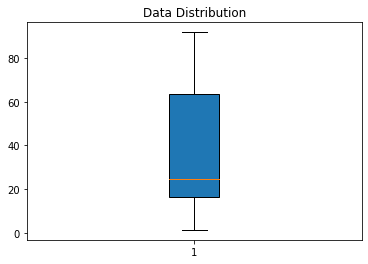

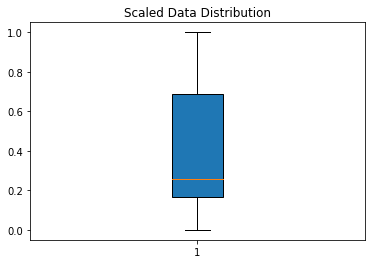

In [5]:
fig1, ax1 = plt.subplots()
ax1.set_title('Data Distribution')
ax1.boxplot(train_data, patch_artist=True)

tempScaler = MinMaxScaler()
scaled_data = tempScaler.fit_transform(train_data)

fig1, ax1 = plt.subplots()
ax1.set_title('Scaled Data Distribution')
ax1.boxplot(scaled_data, patch_artist=True)




We can see scaling our data does not change the distribution

## Prepare Train set

In [6]:
def train_prep(train_data, days, previous):

    scaler = MinMaxScaler((0, 1))
    scaled_train_data = scaler.fit_transform(train_data)

    x_train = [] #Features
    y_train = [] #Labels

    for i in range(previous, scaled_train_data.shape[0], previous+1): #Make windows of 60 days for training until last day

        x_train.append(scaled_train_data[i-previous:i]) #n day window to look back
        y_train.append(scaled_train_data[i:i+days, 0]) #predict for specified days

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    print(x_train.shape, y_train.shape, scaler.scale_)
    
    return x_train, y_train, scaler.scale_
    
x_train, y_train, scale_train = train_prep(train_data, 1, 5)

(527, 5, 1) (527, 1) [0.01108735]


## Prepare test set

In [7]:
def test_prep(test_data, train_data, days, previous):
    
    scaler = MinMaxScaler((0, 1))
    test_data = np.concatenate((train_data[:previous], test_data), axis = 0) #Add last previous observations of train data to test
    scaled_test_data = scaler.fit_transform(test_data)

    x_test = []
    y_test = []

    for i in range(previous, test_data.shape[0], previous+1):
        x_test.append(scaled_test_data[i-previous:i])
        y_test.append(scaled_test_data[i:i+days, 0])

    x_test = np.array(x_test)
    y_test = np.array(y_test)
        
    print(x_test.shape, y_test.shape, scaler.scale_)
    return x_test, y_test, scaler.scale_
    
x_test, y_test, test_scale = test_prep(test_data, train_data, 1, 5)

(66, 5, 1) (66, 1) [0.01021397]


In [8]:
def val_prep(val_data, test_data, days, previous):
    
    scaler = MinMaxScaler((0, 1))
    val_data = np.concatenate((test_data[:previous], val_data), axis = 0) #Add last previous observations of train data to test
    scaled_val_data = scaler.fit_transform(val_data)

    x_val = []
    y_val = []

    for i in range(previous, val_data.shape[0], previous+1):
        x_val.append(scaled_val_data[i-previous:i])
        y_val.append(scaled_val_data[i:i+days, 0])

    x_val = np.array(x_val)
    y_val = np.array(y_val)
        
    print(x_val.shape, y_val.shape, scaler.scale_)
    return x_val, y_val, scaler.scale_
    
x_val, y_val, val_scale = val_prep(val_data, test_data, 1, 5)

(66, 5, 1) (66, 1) [0.02690704]


## Building the LSTM

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5, 64)             12672     
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               74112     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 86,913
Trainable params: 86,913
Non-trainable params: 0
_________________________________________________________________


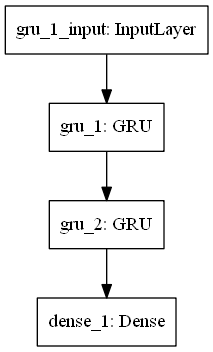

In [9]:
model = Sequential()

model.add(GRU(units = 64, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
#model.add(Dropout(0.2))

model.add(GRU(units = 128, activation = 'relu'))
#model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.summary()

plot_model(model, to_file='model.png')

In [10]:
model.compile(optimizer='adam', loss = 'mean_squared_error')
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data = (x_test, y_test), verbose = 1)






Train on 527 samples, validate on 66 samples
Epoch 1/50
527/527 [==============================] - 1s 2ms/step - loss: 0.1298 - val_loss: 0.1392
Epoch 2/50
527/527 [==============================] - 0s 449us/step - loss: 0.0234 - val_loss: 0.0349
Epoch 3/50
527/527 [==============================] - 0s 440us/step - loss: 0.0088 - val_loss: 0.0112
Epoch 4/50
527/527 [==============================] - 0s 437us/step - loss: 8.2043e-04 - val_loss: 0.0153
Epoch 5/50
527/527 [==============================] - 0s 439us/step - loss: 3.1042e-04 - val_loss: 0.0127
Epoch 6/50
527/527 [==============================] - 0s 444us/step - loss: 2.0332e-04 - val_loss: 0.0130
Epoch 7/50
527/527 [==============================] - 0s 456us/step - loss: 1.9576e-04 - val_loss: 0.0130
Epoch 8/50
527/527 [==============================] - 0s 452us/step - loss: 1.8261e-04 - val_loss: 0.0130
Epoch 9/50
527/527 [==============================] - 0s 441us/step - loss: 1.7720e-04 - val_loss: 0.0131
Epoch 10/50
52

In [11]:
#model = keras.models.load_model(filepath)
model.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['accuracy'])
evaluation = model.evaluate(x_test, y_test)
print(evaluation)

66/66 [==============================] - 0s 2ms/step
[0.013323663954383157, 0.0]


## Testing

In [12]:
y_hat = model.predict(x_test) #Prediction over test set


In [13]:
y_hat_unscaled = y_hat/test_scale[0]
y_test_unscaled = y_test/test_scale[0]

#Scaling back to original values


In [14]:
from sklearn.metrics import mean_squared_error
acc = 100 - mean_squared_error(y_test_unscaled, y_hat_unscaled)
print('Accuracy = ', acc, '%')

Accuracy =  -27.712757833966478 %


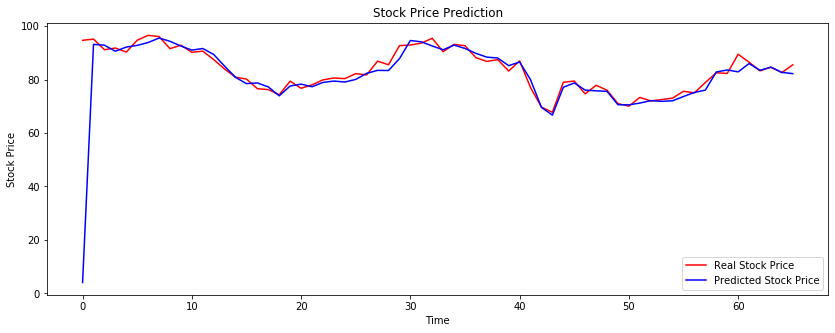

In [15]:
def plot_comparison(y_test, y_hat):

    plt.figure(figsize=(14,5))
    plt.plot(y_test[-100:], color = 'red', label = 'Real Stock Price')
    plt.plot(y_hat[-100:], color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    
plot_comparison(y_test_unscaled, y_hat_unscaled)

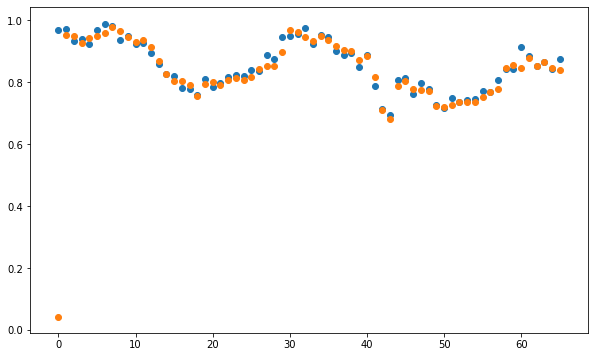

In [16]:
# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))

# Create scatter plot
ax.scatter(range(y_test.shape[0]), 
           y_test)

ax.scatter(range(y_test.shape[0]), 
           y_hat)

plt.show()


## Validating



In [17]:
y_hat_val = model.predict(x_val) #Prediction over val set


In [18]:
y_hat_val_unscaled = y_hat_val/val_scale[0]
y_val_unscaled = y_val/val_scale[0]

#Scaling back to original values


In [19]:
#from sklearn.metrics import mean_squared_error
acc = 100 - mean_squared_error(y_val_unscaled, y_hat_val_unscaled)
print('Accuracy = ', acc, '%')

Accuracy =  85.83270860723246 %


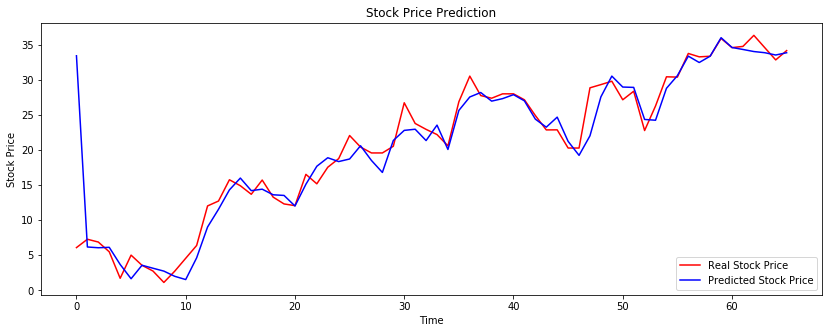

In [20]:
def plot_comparison(y_val, y_val_hat):

    plt.figure(figsize=(14,5))
    plt.plot(y_val[-100:], color = 'red', label = 'Real Stock Price')
    plt.plot(y_val_hat[-100:], color = 'blue', label = 'Predicted Stock Price')
    plt.title('Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    
plot_comparison(y_val_unscaled, y_hat_val_unscaled)